# **<font color = "red">Introduction to Autoregressive Models**


---



## <font color = "blue">**Introduction**
AR model are helpful where current value of a time series can be expressed as a linear combination of its previous values plus a stochastic error term.
<br>In other words, current observations are correlated with past observations.
<br>The AR model's core concept is **autoregression** implying a variable's regression against its own past values.
<br>Today’s value depends on what happened yesterday, the day before, etc
<br>An AR model of order p (denoted as AR(p)) is formulated as:
$$X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + ..... + \phi_p X_{t-p} + ϵ_t$$
where
* $X_t$​ is the current value
* $c$ is a constant
* $\phi$ terms are parameters
* $ϵ_t$​ is white noise.

Let's say we are modeling daily sales.
$$S_t = 10 + 0.6×S_{t-1} + 0.3×S_{t-2} + \epsilon_t$$
Today's sales = 10 + 60% of yesterday’s sales + 30% of day-before-yesterday's sales + randomness

In [53]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

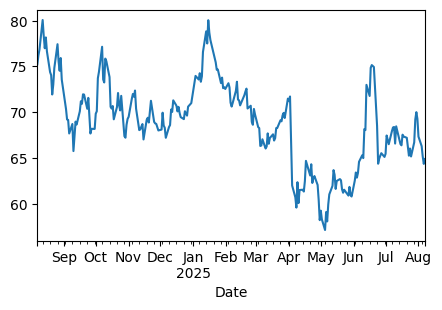

In [54]:
# Fetch WTI Crude Oil futures data
crude_oil_ticker = "CL=F"
crude_oil = yf.Ticker(crude_oil_ticker)
oil_data = crude_oil.history(period="1y", interval="1d")

# Prepare the 'Close' price data for analysis
oil_Close = oil_data['Close']
oil_Close.index = pd.to_datetime(oil_Close.index)
oil_Close_resampled = oil_Close.resample('D').mean().interpolate(method='linear')
oil_Close_resampled.plot(figsize=(5, 3))
plt.show()

###<font color = "green">**When to use AR Model**
If your series is best described by MA(q), you’ll usually see:
* PACF: Sharp cut-off after lag q (values after q are near zero)
* ACF: Gradual decay (tails off slowly).

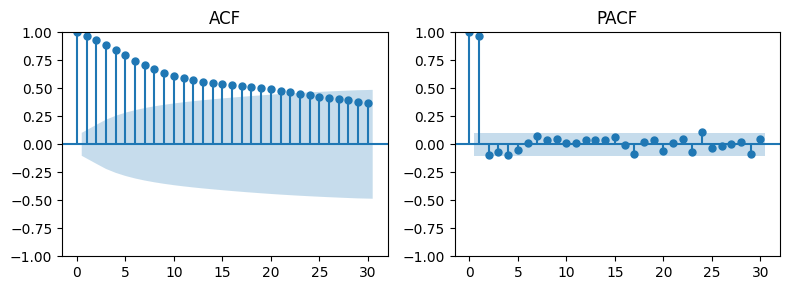

In [55]:
# Create subplots side by side with smaller figure size
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot ACF
plot_acf(oil_Close_resampled, lags=30, ax=axes[0])
axes[0].set_title("ACF")

# Plot PACF
plot_pacf(oil_Close_resampled, lags=30, ax=axes[1])
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

#<font color = "blue"> **Check for Stationarity**
AR models **assumptions**:
* The relationship between current and past values stays consistent over time.
* The parameters (like the coefficients) don't need to change over time.

A **stationary** time series is one where the:
* Mean (average),
* Variance (how spread out the data is), and
* Autocorrelation (relationship with its past values)
stay constant over time.
<br><font color = "red">*A series that behaves the same way all the time — no sudden trends, changing levels, or seasonal ups and downs.*

###<font color = "green"> **Test for Stationarity**
#### **Augmented Dickey-Fuller (ADF)**
$H_0:$ Time series has unit root, meaning it is non-stationary
<br>$H_A:$ Time series doesn't has unit root, meaning it is stationary

In [56]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    result = adfuller(timeseries.values.flatten())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] < 0.01:
        print('Reject the null hypothesis at 99% level of significance. The time series is stationary')
    else:
        print('Fails to reject the null hypothesis at 99% level of significance. The time series is not stationary')

check_stationarity(oil_Close_resampled)

ADF Statistic: -3.199401
p-value: 0.020019
Fails to reject the null hypothesis at 99% level of significance. The time series is not stationary


The results suggest that the oil futures data is likely non-stationary at 99% confidence.

## **<font color = "blue">Making the Time Series Stationary**


### **Time Series Decomposition**
Time series decomposition involves separating the time series into three components:
* **Trend**: The increasing or decreasing value in the series.
* **Seasonality**: The repeating short-term cycle in the series.
* **Residuals**: The random variation in the series.

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

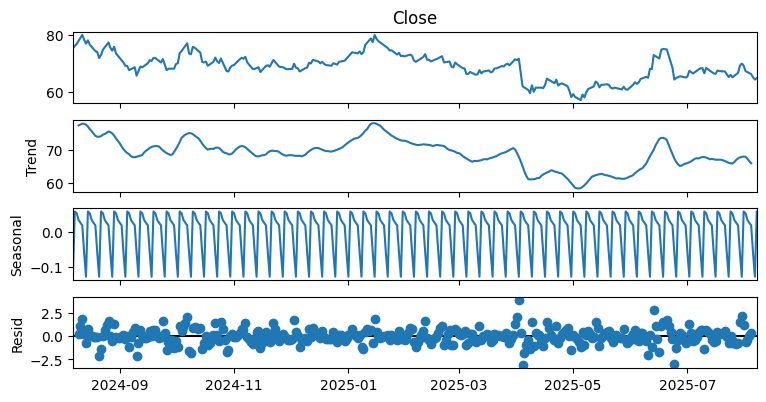

In [58]:
# Decomposing the time series
decomposition = seasonal_decompose(oil_Close_resampled, model='additive')

# Extracting the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting the components
fig = decomposition.plot()
fig.set_size_inches(8, 4)

#### **Analyzing the Residuals**

In [59]:
# Dropping NaN values in residuals
residual.dropna(inplace=True)

# Checking stationarity of residuals
check_stationarity(residual)

ADF Statistic: -8.235766
p-value: 0.000000
Reject the null hypothesis at 99% level of significance. The time series is stationary


# <font color = "blue">**Identifying the Order of the AR Model**


In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order

We can determine the optimal order (p) of an Autoregressive (AR) model without manually inspecting PACF plots and by using information criteria like AIC, BIC, or HQIC.

In [61]:
# Automatically select the best AR order using AIC or BIC
selected_order = ar_select_order(oil_Close_resampled, maxlag=30, ic='aic')  # or ic='bic'

print("Best AR order (p) based on AIC:", selected_order.ar_lags)

Best AR order (p) based on AIC: [1, 2, 3, 4]


#### **PACF Plot**
The PACF plot reveals the extent to which current values of the series are correlated with past values, holding constant the values at all shorter lags.

<Figure size 500x300 with 0 Axes>

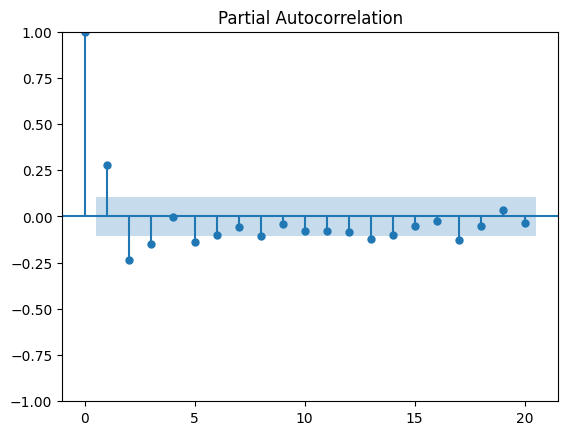

In [62]:
plt.figure(figsize=(5, 3))  # Adjust the width and height as needed
plot_pacf(residual, lags=20)
plt.show()

The significance of the first 4 lags implies that the current value of our time series can be predicted by the values at lags one. Thus, we are inclined to consider an AR model of order 4, denoted as AR(4), where the value of the series at a given time t is influenced by the values at times t−1.

# **<font color = "blue">Estimating Model Parameters**

In [63]:
from statsmodels.tsa.arima.model import ARIMA

In [68]:
p = 4  # Replace with identified order
model = ARIMA(residual, order=(p,0,0))
results = model.fit()

## <font color = "blue">**Visualizing Residuals Predictions**
We plot the historical residuals along with the forecasted values for the next 10 steps. The orange shaded area represents the 95% confidence interval, giving us an estimate of the forecast’s uncertainty. This visual representation is crucial for interpreting the model's predictive power and understanding the potential variability in future values.

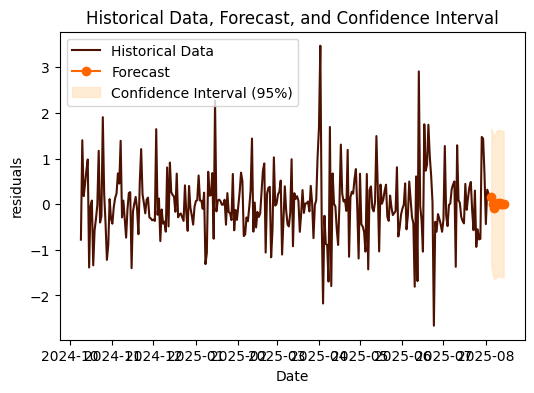

In [69]:
# Extracting residuals from the model
residuals = results.resid

# Forecasting for forecast_steps
forecast_steps = 10
forecast = results.get_forecast(steps=forecast_steps)

# Extracting the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int(alpha=0.05)

# Plotting historical data, forecast points, and confidence intervals
plt.figure(figsize=(6, 4))
plt.plot(residuals.index[-300:], residuals[-300:], label='Historical Data', color='#4C1100')
plt.plot(forecast_values.index, forecast_values, label='Forecast',color='#FF6600',marker='o')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='#FFDBAD', alpha=0.5, label='Confidence Interval (95%)')
plt.xlabel('Date')
plt.ylabel('residuals')
plt.title('Historical Data, Forecast, and Confidence Interval')
plt.legend()
plt.show()

## <font color = "blue">**The Final Forecast of Original Oil Prices**

After modeling and forecasting the residuals, the next critical step is to recombine these forecasts with the trend and seasonal components we initially separated out.
The reconstruction process involves the alignment of our forecasted residuals with the trend and seasonal components, projected into the future.
* Projecting Future Dates: We first generate a sequence of future dates corresponding to the next 10 business days, ensuring our forecast is grounded in the actual timeline of trading days.
* Aligning Forecasts with Future Dates: The forecasted residuals are then indexed to these future dates, providing us with a temporal map of expected values.
* Combining with Trend and Seasonality: We extrapolate the last known values of the trend and seasonal components forward. This step is crucial as it assumes the most recent patterns continue unchanged into the future.
* Adjusting Confidence Intervals: The confidence intervals, originally computed for the residuals, are now adjusted to include the trend and seasonal forecasts. This gives us a range within which we expect the future oil prices to lie, with a certain level of confidence.

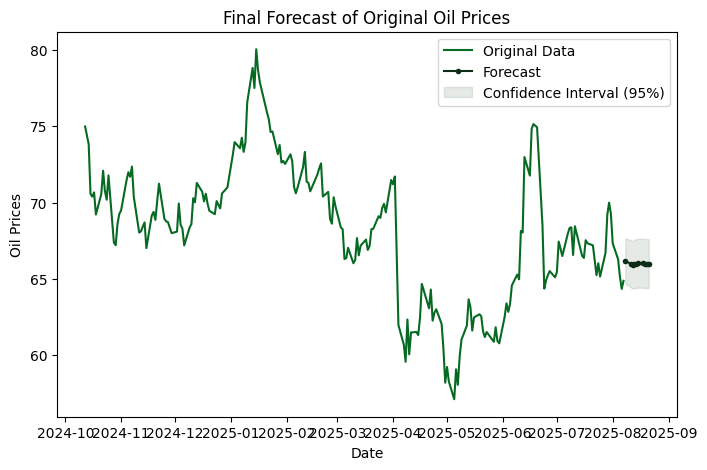

In [79]:
from pandas.tseries.offsets import BDay
import numpy as np

# Fetch WTI Crude Oil futures data
last_date = oil_Close_resampled.index[-1]

# Create a date range for the next 10 business days
future_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq=BDay())[1:]

# Align forecasted values and confidence intervals with future dates
forecast_values.index = future_dates
confidence_intervals.index = future_dates

# Assuming trend and seasonal components are aligned with the original time series

future_trend = np.array([trend.dropna()[-1]] * forecast_steps)  # or a more sophisticated extrapolation
future_seasonal = np.array([seasonal[-1]] * forecast_steps)

# Combine the forecasts with the trend and seasonal components
final_forecast = forecast_values + future_trend + future_seasonal

# Adjust confidence intervals for the full time series
lower_bound = confidence_intervals.iloc[:, 0] + future_trend + future_seasonal
upper_bound = confidence_intervals.iloc[:, 1] + future_trend + future_seasonal

# Plotting the final forecast along with the original time series and confidence intervals
plt.figure(figsize=(8, 5))
plt.plot(oil_Close_resampled.index[-300:], oil_Close_resampled[-300:], label='Original Data', color='#076A23')
plt.plot(future_dates, final_forecast, label='Forecast', color='#0D2D16', marker='.')
plt.fill_between(future_dates, lower_bound, upper_bound, color='#003910', alpha=0.1, label='Confidence Interval (95%)')
plt.xlabel('Date')
plt.ylabel('Oil Prices')
plt.title('Final Forecast of Original Oil Prices')
plt.legend()
plt.show()